<a href="https://colab.research.google.com/github/shanzzenith/Ostromia-civic-os/blob/main/Ostromia-civic-os-V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 7, 0, 1, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (7, 0, 1, 3)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/8 [00:00<?, ?it/s]

Total execution time: 0.06s


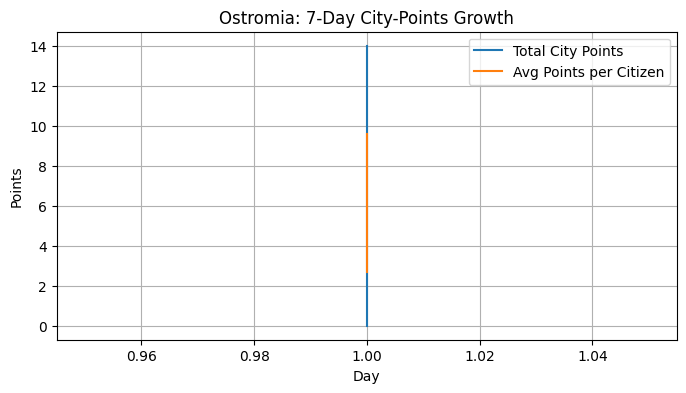

   day  total_supply  avg_points
0    1             0         2.7
1    1             3         4.7
2    1             6         5.3
3    1             7         5.8
4    1             8         6.8
5    1            10         8.5
6    1            14         9.6


In [18]:
# 📦 1) Install cadCAD & friends (pinned versions for Python 3.10)
!pip install --quiet cadCAD==0.5.3 dill==0.3.7 pandas matplotlib

# 🏗️ 2) Ostromia – Minimum-Viable Simulation (7-day demo)
import random, pandas as pd, matplotlib.pyplot as plt
from collections import deque
from cadCAD.configuration import Configuration
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

# ---------- PARAMETERS ----------
NUM_CITIZENS = 10
SIM_DAYS     = 7
MAX_ACTIONS  = 5
A, B         = 0.10, 1.0          # bonding-curve: price = A*supply + B

# ---------- INITIAL STATE ----------
initial_state = {
    "citizens": {f"citizen_{i}": {"points": 0} for i in range(NUM_CITIZENS)},
    "total_supply": 0,
    "daily_log": []
}

# ---------- POLICIES ----------
def civic_actions(p, step, sL, s):
    """Pick random citizens who perform a civic action today."""
    return {"actions": random.choices(list(s["citizens"]),
                                      k=random.randint(1, MAX_ACTIONS))}

# ---------- STATE UPDATES ----------
def update_points(p, step, sL, s, _in):
    citizens, supply = s["citizens"].copy(), s["total_supply"]
    for cid in _in["actions"]:
        price  = A * supply + B
        reward = int(10 / price)
        citizens[cid]["points"] += reward
        supply += 1
    return "citizens", citizens

def update_supply(p, step, sL, s, _in):
    return "total_supply", s["total_supply"] + len(_in["actions"])

def log_day(p, step, sL, s, _in):
    summary = {
        "day": step,
        "total_supply": s["total_supply"],
        "avg_points": sum(c["points"] for c in s["citizens"].values()) / NUM_CITIZENS,
    }
    log = s["daily_log"].copy(); log.append(summary)
    return "daily_log", log

# ---------- PARTIAL STATE UPDATE BLOCK ----------
psubs = [{
    "policies": {"civic_actions": civic_actions},
    "variables": {
        "citizens": update_points,
        "total_supply": update_supply,
        "daily_log": log_day,
    },
}]

# ---------- SIM CONFIG ----------
sim_config = config_sim({"T": range(SIM_DAYS), "N": 1})   # no "M" key

# ---------- CONFIGURATION ----------
configuration = Configuration(
    user_id       = "demo_user",
    model_id      = "ostromia_minimal",
    subset_id     = "run_1",
    subset_window = deque([0]),
    initial_state = initial_state,
    partial_state_update_blocks = psubs,
    sim_config    = sim_config,
)

# ---------- EXECUTION ----------
exec_ctx          = ExecutionContext(context=ExecutionMode().single_mode)
raw_result, *_    = Executor(exec_ctx, configs=[configuration]).execute()
results_df        = pd.DataFrame(raw_result)
daily             = pd.DataFrame(results_df["daily_log"].iloc[-1])

# ---------- VISUALIZATION ----------
plt.figure(figsize=(8,4))
plt.plot(daily["day"], daily["total_supply"], label="Total City Points")
plt.plot(daily["day"], daily["avg_points"],  label="Avg Points per Citizen")
plt.title("Ostromia: 7-Day City-Points Growth")
plt.xlabel("Day"); plt.ylabel("Points"); plt.legend(); plt.grid(); plt.show()

print(daily)


In [14]:
!pip install --quiet cadCAD==0.5.3 dill==0.3.7 pandas matplotlib